# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [1]:
# Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

In [2]:
# Setting predefined arguments.
args = {
    'epoch_num': 50,      # Number of epochs.
    'n_classes': 10,      # Number of classes.
    'lr': 1e-4,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 4,     # Number of workers on data loader.
    'batch_size': 200,    # Mini-batch size.
    'w_size': 224,        # Width size for image resizing.
    'h_size': 224,        # Height size for image resizing.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


Files already downloaded and verified


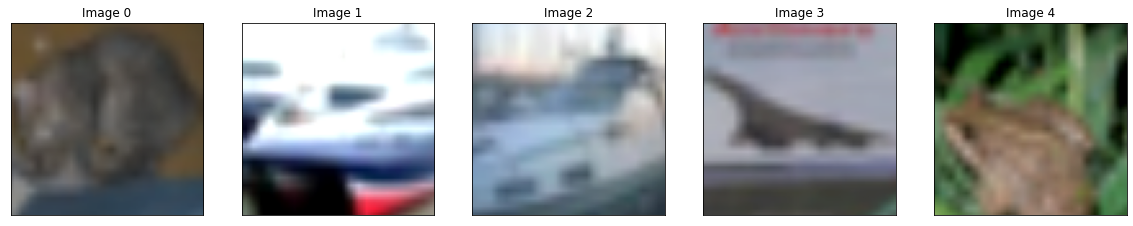

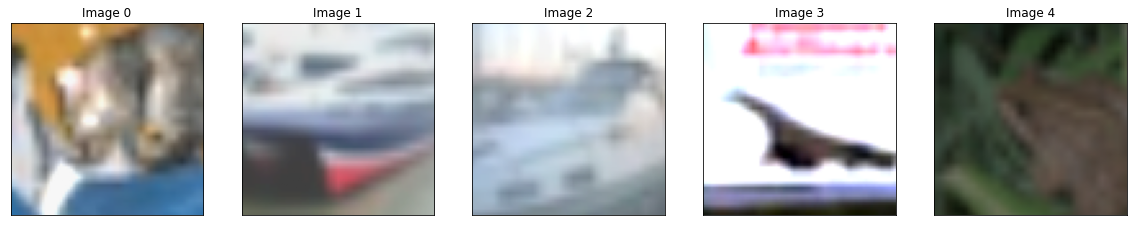

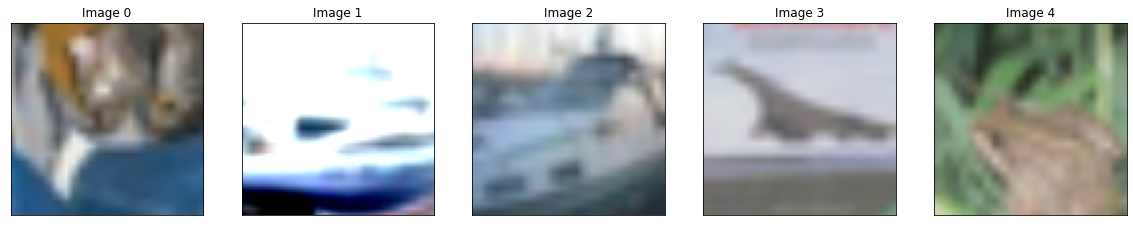

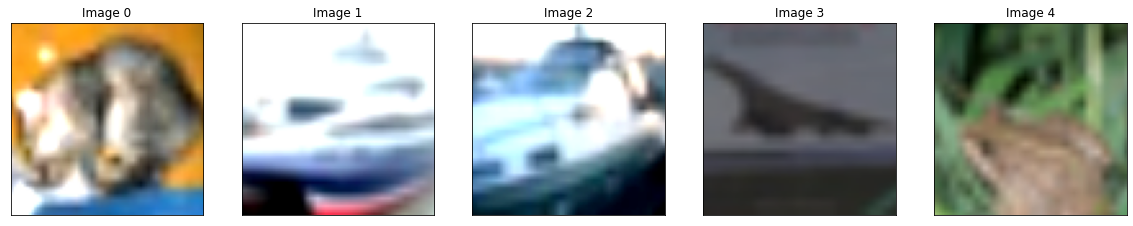

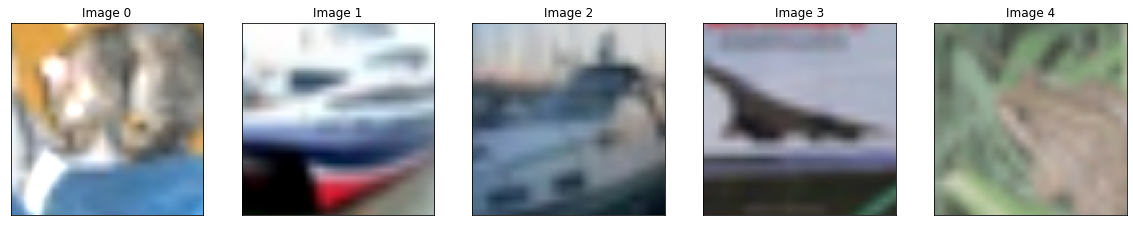

In [3]:
# Root directory for the dataset (to be downloaded).
root = './'

# Data Augmentation transforms.
data_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomCrop((75, 75)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),
])

# Setting datasets and dataloaders.
train_set = datasets.CIFAR10(root,
                             train=True,
                             download=True,
                             transform=data_transform)
test_set = datasets.CIFAR10(root,
                            train=False,
                            download=False,
                            transform=data_transform)
    
for iters in range(5):
    
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))

    for i, test_data in enumerate(test_set):

        if i >= 5:
            break
    
        test_img, _ = test_data

        ax[i].imshow(test_img.numpy().transpose(1, 2, 0))
        ax[i].set_yticks([])
        ax[i].set_xticks([])
        ax[i].set_title('Image ' + str(i))
        
    plt.show()

In [4]:
# Root directory for the dataset (to be downloaded).
root = './'

# Setting transforms (resizing, conversion to tensor and normalizing).
data_transform = transforms.Compose([
    transforms.Resize((args['h_size'], args['w_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Setting datasets and dataloaders.
train_set = datasets.CIFAR10(root,
                             train=True,
                             download=True,
                             transform=data_transform)
test_set = datasets.CIFAR10(root,
                            train=False,
                            download=False,
                            transform=data_transform)

train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

# Printing training and testing dataset sizes.
print('Size of training set: ' + str(len(train_set)) + ' samples')
print('Size of test set: ' + str(len(test_set)) + ' samples')

Files already downloaded and verified
Size of training set: 50000 samples
Size of test set: 10000 samples


# Redes Residuais (ResNets)

Entre 2012 e 2015 a comunidade de Visão Computacional percebeu que redes mais profundas conseguiam capturar características semânticas mais úteis dos dados para tarefas de reconhecimento de imagens (i.e. classificação, segmentação, detecção...). Porém, redes mais profundas que as maiores arquiteturas da época -- como a [VGG](https://arxiv.org/abs/1409.1556) e a [Inception](https://arxiv.org/abs/1409.4842) -- sofriam de um problema chamado **Vanishing Gradient**.

![VGG](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_W640.jpg)

![Inception](https://miro.medium.com/max/700/1*uW81y16b-ptBDV8SIT1beQ.png)


O **Vanishing Gradient** se torna mais problemático em redes mais profundas porque o gradiente dos erros precisa backpropagar desde a última camada até o começo da rede. Dessa forma, as últimas camadas conseguem ser treinadas de forma eficiente, mas o gradiente dos erros vai desaparecendo à medida em que backpropaga pela rede, praticamente impossibilitando o treinamento das primeiras camadas. Assim, foi constatado que uma rede com, por exemplo, 34 camadas acabava por conseguir resultados piores que uma rede com apenas 18 camadas.

![Rede Não Residual](https://www.dropbox.com/s/pq190al5b3qv194/normal_18_vs_34_layers.png?dl=1)

No final de 2015 foi proposta uma solução para o **Vanishing Gradient** na forma de **Blocos Residuais** que, juntos, formam **Redes Residuais** [**(ResNets)**](https://arxiv.org/abs/1512.03385). Esses blocos residuais recebem uma entrada $x$ e a alimentam para um bloco convolucional ($\mathcal{F}(x)$) composto por:

1.   Convolução 3x3;
2.   Batch Normalization;
3.   ReLU;
4.   Convolução 3x3;
5.   Batch Normalization.

A saída $\mathcal{F}(x)$ desse bloco, antes de ser passada por uma segunda ReLU, é passada em conjunto com a entrada $x$ para uma função identidade, que, no caso das **ResNets**, é uma simples soma. Dessa forma, a saída final de um **Bloco Residual** é dada por: $\mathcal{F}(x) + x$. O esquema de um **Bloco Residual** pode ser visto na figura abaixo.

![Bloco Residual](https://www.dropbox.com/s/ezydump33p95ohc/residual_block.png?dl=1)

Como pode ser visto na imagem a seguir, com o uso de blocos residuais, uma arquitetura com 34 camadas consegue resultados melhores que uma arquitetura com apenas 18 camadas. Esses resultados evidenciam que o uso da soma como **identity function** de fato permite que o backward treine mais efetivamente as primeiras camadas das **ResNets**. **ResNets** permitiram que CNNs chegassem até a casa das 100 camadas. A maior **ResNet** usada na prática possui 152 camadas, o que a deixa impraticável de imprimir numa figura como é mostrado abaixo na ResNet34.

![Rede Residual](https://www.dropbox.com/s/q4wcjwf8qj4xjrn/resnet_18_vs_34_layers.png?dl=1)

Como pode ser visto nas imagens abaixo, ResNets (e outras arquiteturas modernas como a [VGG](https://arxiv.org/abs/1409.1556) e as [DenseNets](https://arxiv.org/abs/1608.06993) são compostas basicamente de convoluções com kernels de tamanho 3x3. Além disso, é notável na arquitetura residual (à direita) a presença dos "atalhos" para o gradiente  na forma das funções identidade que ajudam no treinamento das primeiras camadas durante o backpropagation.

![VGG vs. Plain34 vs. ResNet34](https://www.dropbox.com/s/d2w3h7dlumgclx2/vgg_plain34_resnet34.png?dl=1)

# Atividade Prática

1.   Implementar a classe *ResidualBlock()*. Devem ser implementados os

In [5]:
# Implementation of residual block to be reused.
class ResidualBlock(nn.Module):
    
    def __init__(self, in_planes, out_planes):
        
        super(ResidualBlock, self).__init__()
        
        # First conv block.
        self.conv1 = nn.Conv2d(in_planes,
                               out_planes,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(out_planes)
        
        # Second conv block.
        self.conv2 = nn.Conv2d(out_planes,
                               out_planes,
                               kernel_size=3,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        # Activation for both blocks.
        self.relu = nn.ReLU(inplace=True)
        
        # If in_planes != out_planes, perform a 1x1 conv to match #channels.
        self.conv1x1 = None
        if in_planes != out_planes:
            self.conv1x1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, padding=0)

    def forward(self, x):
        
        identity = x

        # First conv block.
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second conv block.
        out = self.conv2(out)
        out = self.bn2(out)
        if self.conv1x1 is not None:
            identity = self.conv1x1(identity)
        out += identity # Sum of output and identity.
        out = self.relu(out)

        return out

# ResNet18 implementation.
class ResNet18(nn.Module):
    
    def __init__(self, num_classes=10):

        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3,
                               64,
                               kernel_size=7,
                               stride=2,
                               padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3,
                                     stride=2,
                                     padding=1)
        
        self.res_block1 = ResidualBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3,
                                     stride=2,
                                     padding=1)
        self.res_block2 = ResidualBlock(64, 128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3,
                                     stride=2,
                                     padding=1)
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Linear(128, num_classes)
        
        self.initialize_weights()
    
    # Function for randomly initializing weights.
    def initialize_weights(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        
        # First convolution block.
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        
        # First residual block.
        out = self.res_block1(out)
        out = self.maxpool2(out)
        
        # Second residual block.
        out = self.res_block2(out)
        out = self.maxpool3(out)
        
        # Adaptive Average Pooling for consistent output size of 1x1.
        out = self.adaptive_pool(out)
        
        # Linearizing trailling dimensions.
        out = out.view(x.size(0), -1)
        
        # Inference layer.
        out = self.classifier(out)
        
        return out

# Instantiating architecture.
net = ResNet18(args['n_classes']).to(args['device'])

# Printing architecture.
print(net)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_block1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (res_block2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [6]:
# Using predefined and pretrained model of ResNet18 on torchvision.
# net = models.resnet18(pretrained=True, progress=False).to(args['device'])
# net.fc = nn.Linear(in_features=512, out_features=10, bias=True).to(args['device'])

# Shrunk version of ResNet18 to be used in class.
# net = models.resnet18(pretrained=True, progress=False).to(args['device'])
# net.layer3 = nn.Sequential().to(args['device']) # Uncomment to shrink ResNet.
# net.layer4 = nn.Sequential().to(args['device']) # Uncomment to shrink ResNet.
# net.fc = nn.Linear(in_features=128, out_features=10, bias=True).to(args['device'])

# Definindo o otimizador

O Pytorch possui vários otimizadores prontos no subpacote [optim](https://pytorch.org/docs/stable/optim.html), desde o SGD básico a otimizadores mais complexos e com taxas de aprendizado por parâmetro como o Adagrad, RMSProp e Adam.

In [7]:
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       betas=(args['momentum'], 0.999),
                       weight_decay=args['weight_decay'])

# Definindo a loss

O subpacote [nn](https://pytorch.org/docs/stable/nn.html) possui várias funções de perda para diferentes tarefas (i.e. Cross Entropy, Negative Log Likelihood, loss L1, MSE, Kullback Leibler Divergence, etc) implementadas por padrão.



In [8]:
criterion = nn.CrossEntropyLoss().to(args['device'])

# Criando funções para Treino e Teste

Iterando sobre os datasets/dataloaders de treino e teste do CIFAR10. Abaixo são implementadas a função *train()* que itera sobre os batches do dataset de treino e atualiza o modelo e a função *test()* que apenas realiza o forward dos dados de teste no modelo e calcula a acurácia no dataset de teste para o modelo no estado atual.

In [9]:
def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        inps, labs = batch_data
        
        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])
        
        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs = net(inps)

        # Computing loss.
        loss = criterion(outs, labs)

        # Computing backpropagation.
        loss.backward()
        optimizer.step()
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), (toc - tic)))
    print('--------------------------------------------------------------------')
    
def test(test_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode (not computing gradients).
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    prd_list = []
    lab_list = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        inps, labs = batch_data

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # Forwarding.
        outs = net(inps)

        # Computing loss.
        loss = criterion(outs, labs)
        
        # Obtaining predictions.
        prds = outs.data.max(dim=1)[1].cpu().numpy()
        
        # Updating lists.
        test_loss.append(loss.data.item())
        prd_list.append(prds)
        lab_list.append(labs.detach().cpu().numpy())
    
    toc = time.time()
    
    # Computing accuracy.
    acc = metrics.accuracy_score(np.asarray(lab_list).ravel(),
                                 np.asarray(prd_list).ravel())
    
    test_loss = np.asarray(test_loss)
    
    # Printing training epoch loss and metrics.
    print('--------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [acc %.4f], [testing time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), acc, (toc - tic)))
    print('--------------------------------------------------------------------')

# Iterando sobre epochs

In [10]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    test(test_loader, net, criterion, epoch)

--------------------------------------------------------------------
[epoch 1], [train loss 1.9203 +/- 0.1592], [training time 94.18]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 1], [test loss 1.7182 +/- 0.0436], [acc 0.3877], [testing time 82.80]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2], [train loss 1.6175 +/- 0.0753], [training time 94.74]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2], [test loss 1.5699 +/- 0.0564], [acc 0.4421], [testing time 82.86]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 3], [train loss 1.4626 +/- 0.0653], [training time 95.84]
------------------------------